In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import Generator, Discriminator, train_model
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms as T
import torchvision.utils as vutils
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from msapy import msa
import pickle as pkl
import ipywidgets as widgets
from ipywidgets import interact, fixed
import msa_utils
import bct
from netneurotools import cluster
from collections import Counter
from sklearn.cluster import SpectralClustering

SEED = 42
RNG = np.random.default_rng(SEED)
matplotlib.rcParams['figure.figsize'] = (12, 6)
torch.manual_seed(SEED)

In [3]:
workers = 4
batch_size = 128
image_size = 64

nc = 1
nz = 100
ngf = 64
ndf = 64
num_layers = 5

lr = 0.0002
num_epochs = 30
num_permutations = 3000

dataroot = "data/celebA"
device = "cuda:0"
model_path = "saved_results/celebA_GAN_model.pth"
shapley_modes_path = "saved_results/shapley_modes_celebA.pkl"

Files already downloaded and verified


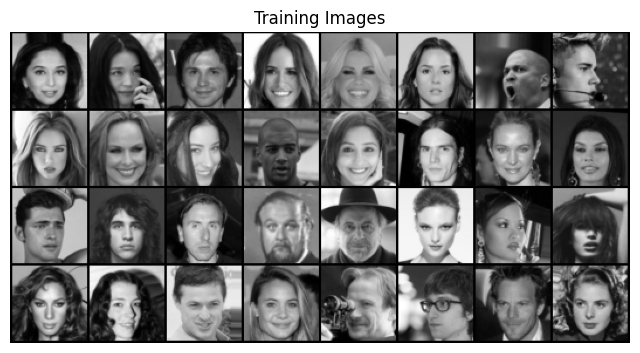

In [4]:
dataset = datasets.CelebA(root=dataroot,
                        split='train',
                        transform=T.Compose([
                               T.CenterCrop(160),
                               T.Resize(image_size),
                               T.Grayscale(),
                               T.ToTensor(),
                           ]),
                        download=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=False).cpu(),(1,2,0)))

In [7]:
generator = Generator(nz, ngf, nc, num_layers).to(device)
discriminator = Discriminator(nc, ndf, num_layers).to(device)

fixed_noise = torch.load('fixed_noise.t').to(device)

In [ ]:
image_list = train_model(generator, discriminator, num_epochs, lr, dataloader, nz, fixed_noise, save_every=500, device=device)

In [6]:
#torch.save(generator.state_dict(), model_path)

In [7]:
generator.load_state_dict(torch.load(model_path))
generator.eval();

In [9]:
def display_images(images):
    """
    Display images with a slider.
    
    Parameters:
    - images: A list of numpy ndarrays representing the images.
    """
    
    def view_image(index):
        plt.imshow(images[index]) # Assuming the images are in grayscale
        plt.axis('off') # Hide axes
        plt.show()
    
    # Slider
    widgets.interact(view_image, index=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0))

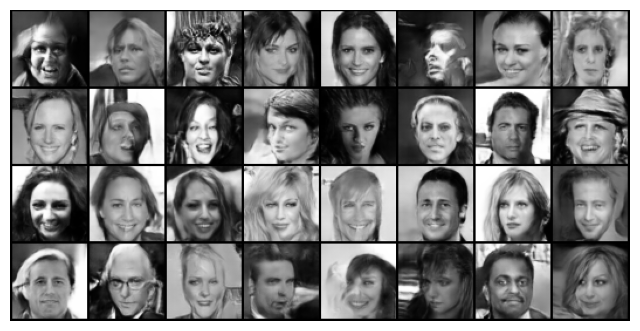

In [10]:
generator.eval()
final_fake_images = generator(fixed_noise).cpu().detach()
final_fake_images = vutils.make_grid(final_fake_images, padding=2, normalize=True)
final_fake_images = final_fake_images.numpy().transpose(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(final_fake_images)
plt.show()

In [17]:
elements = []
x = 2**(num_layers - 2)
elements = [(0, i) for i in range(ngf * 2**(num_layers - 2))]
elements += [(i, j) for i in range(1, 4) for j in range(ngf * 2 ** (num_layers -2 - i))]
elements += [(5, i) for i in range(1)]
len(elements)

961

In [18]:
shapley_modes = msa.interface(
    elements=elements,
    n_permutations=num_permutations, 
    objective_function=partial(msa_utils.objective_function, generator=generator, fixed_noise=fixed_noise),
    rng=RNG)

KeyboardInterrupt: 

In [ ]:
#shapley_modes.to_pickle(shapley_modes_path)

In [11]:
with open(shapley_modes_path, 'rb') as fp:
    shapley_modes = pkl.load(fp)

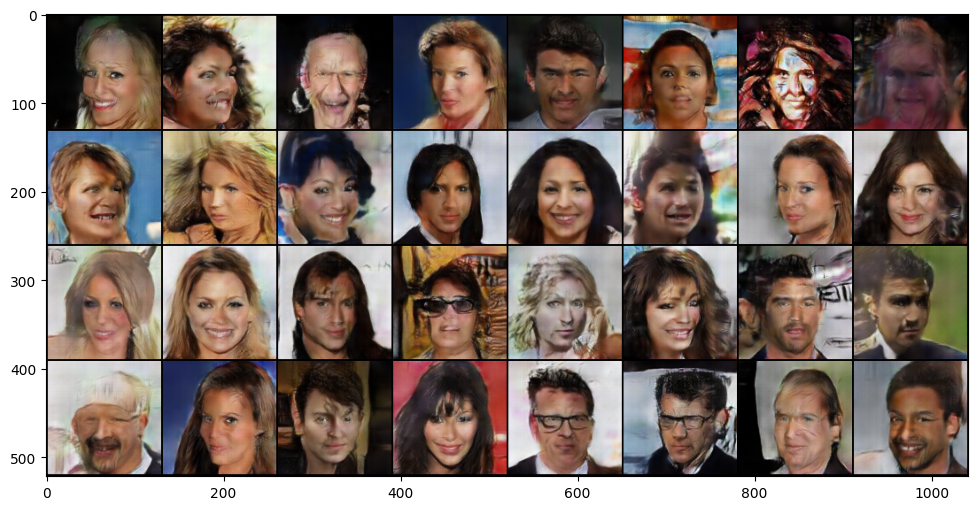

In [16]:
plt.imshow(msa_utils.convert_to_image_grid(shapley_modes.get_total_contributions()))

In [17]:
layer = 5

ims = [msa_utils.convert_to_image_grid(layer_contrib) for layer_contrib in msa_utils.get_layer_contributions(layer, shapley_modes)]
display_images(ims)

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [18]:
layer = 3

ims = [msa_utils.convert_to_image_grid(layer_contrib) for layer_contrib in msa_utils.get_layer_contributions(layer, shapley_modes)]
display_images(ims)

interactive(children=(IntSlider(value=0, description='index', max=127), Output()), _dom_classes=('widget-inter…

In [ ]:
n_clusters = 15

model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans')
labels = msa_utils.cluster_modes(shapley_modes, model.fit_predict, [0, 10, 17, 31])

In [31]:
Counter(labels)

Counter({13: 1158,
         1: 479,
         14: 70,
         0: 40,
         6: 37,
         5: 32,
         9: 28,
         12: 24,
         7: 24,
         10: 22,
         2: 19,
         8: 15,
         3: 14,
         4: 13,
         11: 12})

In [54]:
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements, labels, [11], generator, fixed_noise,)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [54]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=True)


Using cache found in /home/shrey/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub
/home/shrey/miniconda3/envs/msa-xai/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to /home/shrey/.cache/torch/hub/checkpoints/DCGAN_fashionGen-1d67302.pth
100%|██████████| 39.7M/39.7M [00:02<00:00, 14.3MB/s]


Average network found !


In [65]:
netG = model.getNetG()

In [69]:
netG.main??

Signature:      netG.main(*args, **kwargs)
Type:           Sequential
String form:   
Sequential(
  (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (convTranspose1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (convTranspose2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (convTranspose3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (outlayer): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2